# Simulation of Complex Systems - Chapter 13
**Author**: Artur Gasparyan

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

seed = 69420
rng = np.random.default_rng(seed)

## Exercise 13.1

In [194]:
def get_outcomes(T, R, P, S):
    assert T < R < P < S
    
    # Betray = 0
    # Cooperate = 1

    # 0,0 -> P,P
    # 0,1 -> T,S
    # 1,0 -> S,T
    # 1,1 -> R,R
    
    return np.array([
        [[P, P], [T, S]],
        [[S, T], [R, R]]
    ])

In [195]:
def get_years(N, outcomes):
    years_all = np.zeros((N, N, N, 2))

    for n in range(N):
        for m in range(N):
            d1 = np.ones(N, dtype=int)
            d2 = np.ones(N, dtype=int)
            if n < m:
                d1[n:] = 0
                d2[n+1:] = 0
            elif n > m:
                d1[m+1:] = 0
                d2[m:] = 0
            else:
                d1[m:]= 0
                d2[m:]= 0

            outcome = outcomes[d1, d2]
            years_all[n, m, :, :] = outcome
            
    return years_all

In [196]:
N = 10
T = 0
R = 0.5
P = 1
S = 1.5

outcomes = get_outcomes(T, R, P, S)
years_all = get_years(N, outcomes)

In [197]:
def plot_1d(years_all, fig, ax):
    years = years_all[:, 6, :, 0]
    acc_years = np.sum(years, axis=1)
    ax.scatter(np.arange(N), acc_years)
    ax.axvline(6, c='red')
    ax.legend(["outcome", "m"])
    ax.set_ylim(5, 10)
    ax.set_xlabel('n')
    ax.set_ylabel('years')


In [198]:
def plot_2d(years_all, fig, ax):
    years = years_all[:, :, :, 0]
    acc_years = np.sum(years, axis=2)
    im = ax.imshow(acc_years, origin='lower')
    ax.plot(np.arange(1, N), np.arange(N-1), linestyle='--', c='white')
    fig.colorbar(im, ax=ax, label='prison years')
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.legend(["n = m - 1"])

<IPython.core.display.Javascript object>


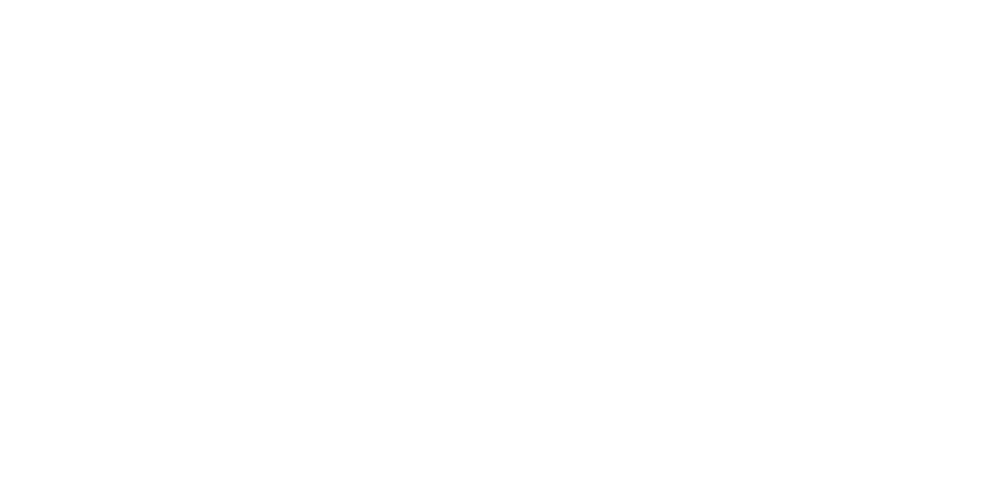

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plot_1d(years_all, fig=fig, ax=ax1)
plot_2d(years_all, fig=fig, ax=ax2)


<IPython.core.display.Javascript object>


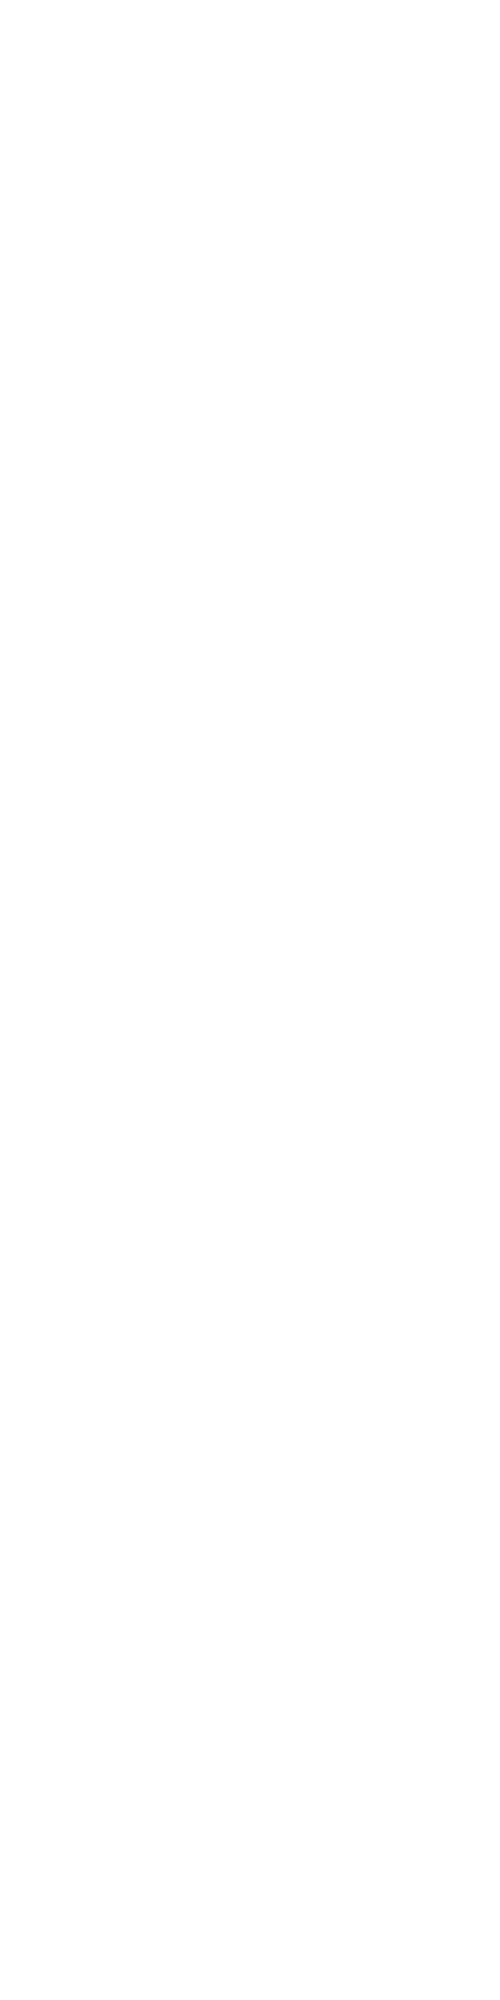

In [200]:
N = 10
T = 0
P = 1

Rs = [0.25, 0.5, 0.75, 0.001]
Ss = [1.25, 1.5, 1.75, 1.999]
n_plots = len(Rs)

fig, axes = plt.subplots(n_plots, 1, figsize=(4, 4*n_plots))
fig.suptitle("Years in prison plotted for varying R, S")

for i in range(n_plots):
    R = Rs[i]
    S = Ss[i]
    ax = axes[i]
    ax.set_title(f'R: {R}, S: {S}')
    
    outcomes = get_outcomes(T, R, P, S)
    years_all = get_years(N, outcomes)
    plot_2d(years_all, fig, ax)
    
    

## Exercise 13.2

In [201]:
def create_strategy(shape, default_value, place_values):
    strats = default_value*np.ones(shape, dtype=int)
    for v, ys, xs in place_values:
        strats[ys, xs] = v

    return strats 


create_strategy((5, 5), 2, [(0, [2], [2])])

array([[2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 0, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2]])

In [202]:
def frame(i):
    ax = plt.gca()
    ax.clear()
    x = np.arange(10)
    y = x.copy()
    y[i%10] = 1
    plot = ax.plot(x, y)
    return plot

In [203]:
def play_round(N, n, m, outcomes):
    d1 = np.ones(N, dtype=int)
    d2 = np.ones(N, dtype=int)
    
    if n < m:
        m = n+1
    elif m < n:
        n = m+1

    d1[n:] = 0
    d2[m:] = 0
    
    return outcomes[d1, d2]


def test_play_round():
    N = 10
    T = 0
    R = 0.5
    P = 1
    S = 1.5
    
    outcomes = get_outcomes(T, R, P, S)
    n = 5
    m = 6
    
    outcome = play_round(N, n, m, outcomes)
    expected_outcome = [
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.,  1.5],
        [1.,  1. ],
        [1.,  1. ],
        [1.,  1. ],
        [1.,  1. ]
    ]
    
    assert np.all(np.isclose(outcome, expected_outcome))    
    
test_play_round()

In [204]:
def play_competition(N, outcomes, offsets, strats):
    L = strats.shape[0]
    scores = np.zeros((L, L))

    for y in range(L):
        for x in range(L):
            score = 0

            for (dy, dx) in offsets:
                n = strats[y, x]
                m = strats[(y+dy)%L, (x+dx)%L]

                n_years = play_round(N, n, m, outcomes)
                score += np.sum(n_years[:, 0])

            scores[y, x] = score
        
    return scores

In [205]:
def revise_strats(strats, scores):
    L = strats.shape[0]
    n_offsets = len(offsets)
    new_strats = np.zeros(strats.shape, int)
    
    
    for y in range(L):
        for x in range(L):
            min_score = scores[y, x]
            min_pos = [(y, x)]
            
            for i, (dy, dx) in enumerate(offsets):
                p = ny, nx = (y+dy)%L, (x+dx)%L
                score = scores[ny, nx]
                
                if score < min_score:
                    #print("MINLESS", score, min_score, p)
                    min_score = score
                    min_pos = [p]
                    
                elif score == min_score:
                    min_pos.append(p)
                    
            p_choice = rng.choice(min_pos)
            new_strats[y, x] = strats[p_choice[0], p_choice[1]]
            
    return new_strats
            

                    
    ...

In [206]:
def mutate_strats(strats, N, mu):
    new_strats = strats.copy()
    
    mutation_indexes = rng.random(size=new_strats.shape) < mu
    new_strats[mutation_indexes] = rng.integers(0, N, size=mutation_indexes.sum(), dtype=strats.dtype, endpoint=True)
    
    return new_strats

In [207]:
def run_sim(n_timesteps, strats_start, N, L, T, P, S, R, mu):
    outcomes = get_outcomes(T, R, P, S)

    offsets = np.array(((1, 0), (0, 1), (-1, 0), (0, -1)))

    #strats = N*np.ones((L, L), dtype=int)
    #strats[L//2, L//2] = 0
    strats = strats_start.copy()
    
    history = [strats]
    for i in range(1, n_timesteps):
        scores = play_competition(N, outcomes, offsets, strats)
        strats = revise_strats(strats, scores)
        strats = mutate_strats(strats, N, mu)
        history.append(strats)
        
    return history

<IPython.core.display.Javascript object>


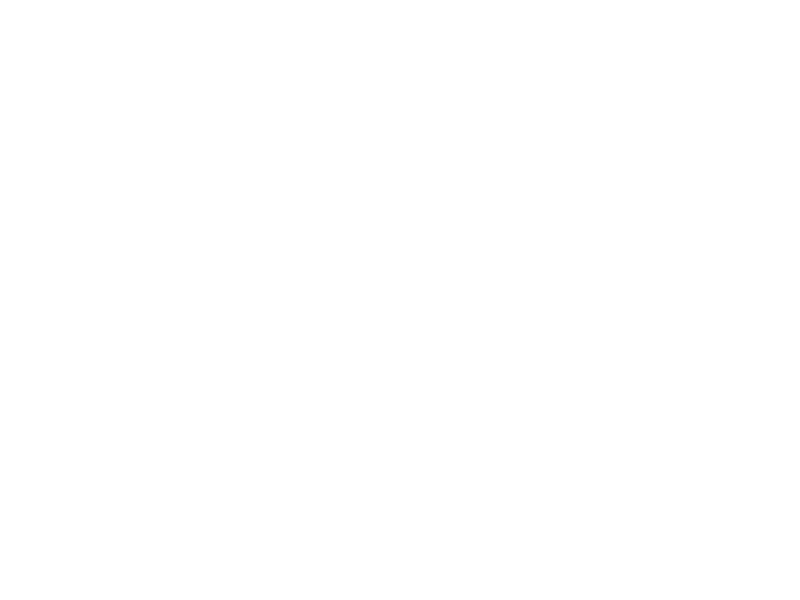

In [208]:
%matplotlib notebook


def draw_frame(i_frame, ax, history):
    strat = history[i_frame]
    ax.imshow(strat)
    ax.set_title(f"t={i_frame}")
    

N = 7
L = 30
T = 0
P = 1
R = 0.9
S = 1.5
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)
history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)

fig = plt.figure()
ax = fig.gca()
animation = anim.FuncAnimation(fig, draw_frame, frames=len(history), fargs=(ax, history), repeat=False)
    

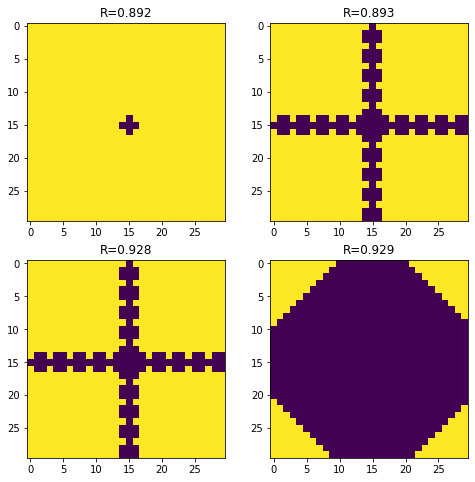

In [209]:
%matplotlib inline

N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Rs = [0.892, 0.893, 0.928, 0.929]       # min: 0.892, max: 0.928
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax = axes.flatten()[i]
    ax.imshow(history[-1])
    ax.set_title(f"R={R}")

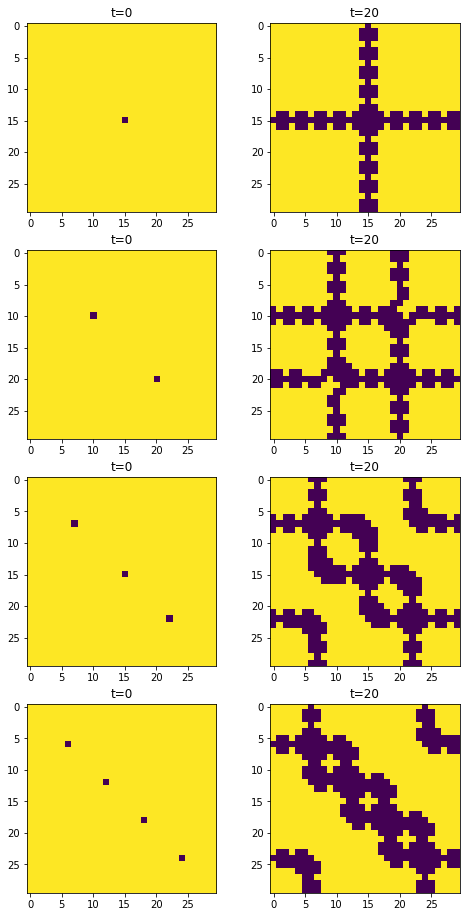

In [213]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
R = 0.9
mu = 0
n_timesteps = 21
stratss = [
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//2], [L//2])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//3, 2*L//3], [L//3, 2*L//3])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//4, 2*L//4, 3*L//4], [L//4, 2*L//4, 3*L//4])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//5, 2*L//5, 3*L//5, 4*L//5], [L//5, 2*L//5, 3*L//5, 4*L//5])]
    ),   
]

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
for i, strats in enumerate(stratss):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax1.set_title("t=0")
    ax2.imshow(history[-1])
    ax2.set_title(f"t={n_timesteps-1}")

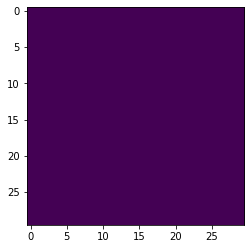

In [219]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
R = 0.9
mu = 0
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=0,
    place_values = [(N, [L//2], [L//2])]
)
history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)

fig = plt.figure()
plt.imshow(history[-1])

...;

## Exercise 13.3

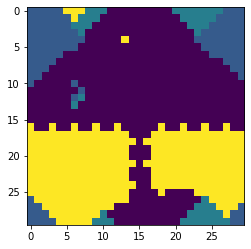

In [212]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
R = 0.9
mu = 0.0001

n_timesteps = 20
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)

fig = plt.figure()
plt.imshow(history[-1])